In [1]:
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the data

routine.py

In [2]:
def coth(a):
    if a>0: return (1+np.exp(-2*a))/(1-np.exp(-2*a))
    if a<0: return (np.exp(2*a)+1)/(np.exp(2*a)-1)
    if a==0: return 0

m2=-1.0
lamb=1.0
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
h_real=np.array([3*coth(3*((i-N_layer)*del_eta)) for i in range (N_layer)])

def LP2(hh, phi, pi):
    for j in range (N_layer-1):
        phi1=phi+del_eta*pi
        pi1 =phi*m2*del_eta+(1-del_eta*hh[j])*pi+del_eta*lamb*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi

def F_func(a,b):
    return 2*b/eta_fin-m2*a-lamb*(a**3)

def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

def generate_data(datasize=1000, Hrange=[0.0, 1.5], Mrange=[-0.2, 0.2]):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1], datasize)
        M=np.random.uniform(Mrange[0], Mrange[1], datasize)
        HH, MM = LP2(h_real, H, M)
        F=np.array(np.abs(F_func(HH, MM)))
        for i in range (len(H[F<0.1])):
            if len(Fp)>=datasize: break
            Hp.append([H[F<0.1][i]])
            Mp.append([M[F<0.1][i]])
            Fp.append([0])
        for j in range (len(H[F>=0.1])):
            if len(Fn)>=datasize: break
            Hn.append([H[F>=0.1][j]])
            Mn.append([M[F>=0.1][j]])
            Fn.append([1])
        if len(Fp)>=datasize and len(Fn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(Positive_HM, Negative_HM):
    print(len(Positive_HM[2]), len(Negative_HM[2]))
    plt.xlabel('phi')
    plt.ylabel('pi')
    plt.plot(Negative_HM[0], Negative_HM[1], 'g.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'r.', label='positive')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

1000 1000


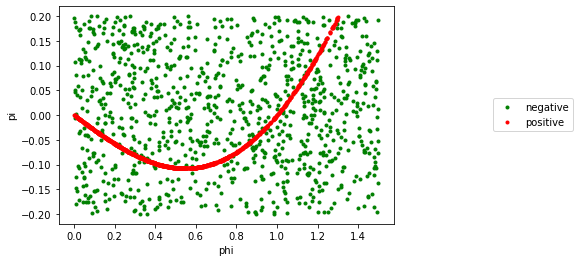

In [3]:
Positive_HM, Negative_HM = generate_data(datasize=1000)
plot_all(Positive_HM, Negative_HM)

## Reformat training data
Make training data by class called 'Dataset'.

In [4]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def f(phi, pi):
    return pi

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        
        #fixed parameters
        self.lamb=lamb
        self.m2=m2
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
    
    def show_Hs(self):
        a=[]
        for i in range (N_layer):
            aa=self.Hs[i](self.one).data.numpy()[0]
            a.append(aa)
        return a
    
    def penalty(self):
        pen=0
        for i in range (self.N_layer-1):
            H1=self.Hs[i](self.one)
            H2=self.Hs[i+1](self.one)
            pen=pen+c_reg1*((eta_ini+i*del_eta)**4)*((H2-H1)**2)
        pen=pen+c_reg2*((self.Hs[N_layer-1](self.one)-N_layer)**2)
        return pen
    
    def forward(self, phi=None, pi=None):
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2, 
                              lamb=self.lamb, del_eta=self.del_eta)
        ff=f(phi, pi)
        final=t(ff)
        return final
    
    def loss(self, phi=None, pi=None, answer=None):
        model_output=self.forward(phi=phi, pi=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty()
        return loss

def init_weights(Model):
    for i in range (len(Model.Hs)):
        mu=1/(eta_ini+del_eta*i)
        w=np.random.normal(mu, 1)
        Model.Hs[i].weight.data.fill_(w)   

In [7]:
c_reg1=0.001
c_reg2=0.000

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta)
init_weights(Test)

In [8]:
#setting it to be trained
optimizer = torch.optim.Adam(Test.parameters())
Test.train()

Metricnet(
  (Hs): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): Linear(in_features=1, out_features=1, bias=False)
    (2): Linear(in_features=1, out_features=1, bias=False)
    (3): Linear(in_features=1, out_features=1, bias=False)
    (4): Linear(in_features=1, out_features=1, bias=False)
    (5): Linear(in_features=1, out_features=1, bias=False)
    (6): Linear(in_features=1, out_features=1, bias=False)
    (7): Linear(in_features=1, out_features=1, bias=False)
    (8): Linear(in_features=1, out_features=1, bias=False)
    (9): Linear(in_features=1, out_features=1, bias=False)
  )
)

# 3. Train NN

In [9]:
def plot_metric(threshold=None, Positive_HM=None, Negative_HM=None, Net=None):
    NN_pphi=[]
    NN_ppi=[]
    Negative_H = Negative_HM[0]
    Negative_M = Negative_HM[1]
    phis = Variable(torch.from_numpy(Negative_H.astype(np.float32)))
    pis = Variable(torch.from_numpy(Negative_M.astype(np.float32)))
    predict = Net.forward(phi=phis, pi=pis).data.numpy()
    
    for index in range (len(Negative_H)):
        value = predict[index]
        if value < threshold:
            NN_pphi.append(Negative_H[index])
            NN_ppi.append(Negative_M[index])
    NN_pphi1=np.array(NN_pphi)
    NN_ppi1=np.array(NN_ppi)
    
    NN_pphi=[]
    NN_ppi=[]
    Positive_H = Positive_HM[0]
    Positive_M = Positive_HM[1]
    phis = Variable(torch.from_numpy(Positive_H.astype(np.float32)))
    pis = Variable(torch.from_numpy(Positive_M.astype(np.float32)))
    predict = Net.forward(phi=phis, pi=pis).data.numpy()
    
    for index in range (len(phis)):
        value = predict[index]
        if value < threshold:
            NN_pphi.append(Positive_H[index])
            NN_ppi.append(Positive_M[index])
    NN_pphi2=np.array(NN_pphi)
    NN_ppi2=np.array(NN_ppi)
    
    plt.plot(NN_pphi1, NN_ppi1, 'm.', label='NN(n)=0')
    plt.plot(NN_pphi2, NN_ppi2, 'r.', label='NN(p)=0')
    plt.show()
    
    x = np.array([0.1*i for i in range (10)])
    NN_list=[]
    for param in Net.Hs.parameters():
        w = (param.data.numpy().reshape(-1)).tolist()
        NN_list.append(w)
    plt.plot(x, h_real, 'r-')
    plt.plot(x, np.array(NN_list), 'k-')
    plt.show()
    
    return NN_pphi1, NN_ppi1, NN_pphi2, NN_ppi2, NN_list

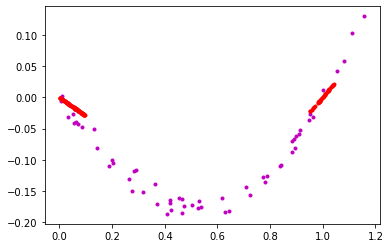

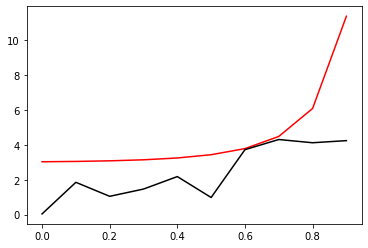

0 tensor(0.2113) [0.034042623, 1.8481266, 1.0438898, 1.4604496, 2.1772988, 0.9766508, 3.722203, 4.3045726, 4.1188836, 4.240411]


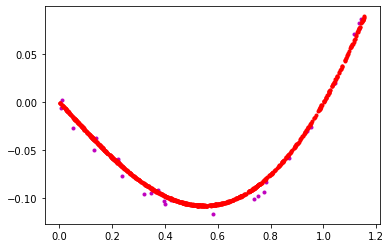

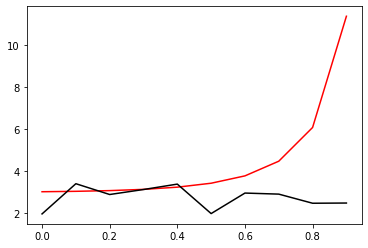

100 tensor(0.0059) [1.9714805, 3.409595, 2.895246, 3.1327298, 3.3902261, 1.9876274, 2.9640017, 2.9134076, 2.4795973, 2.4893126]


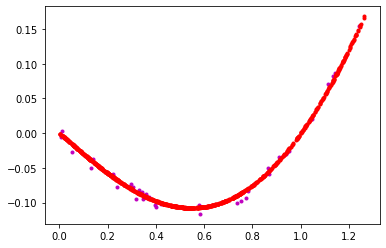

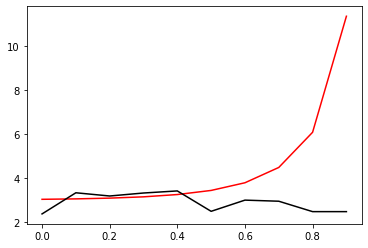

200 tensor(0.0020) [2.3607774, 3.3251755, 3.1784322, 3.314741, 3.4095974, 2.479254, 2.9900908, 2.9399993, 2.4649584, 2.464958]


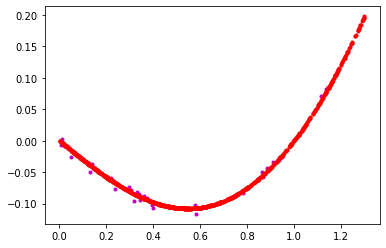

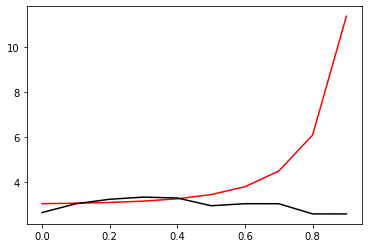

300 tensor(0.0008) [2.6307447, 3.0236022, 3.22354, 3.3187423, 3.2790418, 2.9347932, 3.0250866, 3.0240924, 2.5712469, 2.5702534]


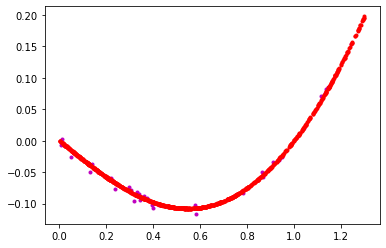

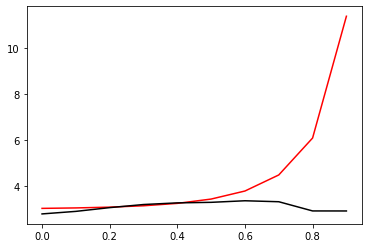

400 tensor(0.0006) [2.7863982, 2.8968976, 3.0599735, 3.1945305, 3.266351, 3.2899823, 3.3582726, 3.316053, 2.9159825, 2.9145265]


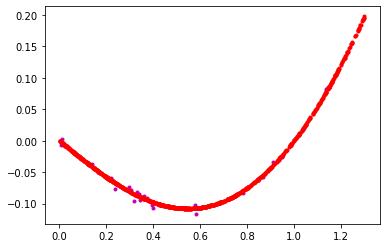

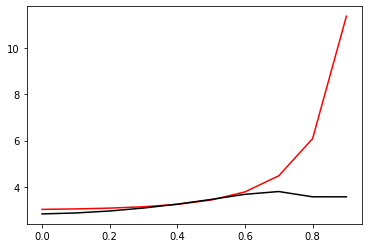

500 tensor(0.0006) [2.8304577, 2.871974, 2.9572656, 3.0846343, 3.252309, 3.4568975, 3.6785176, 3.7983148, 3.5702226, 3.5694666]


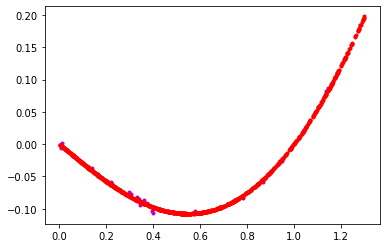

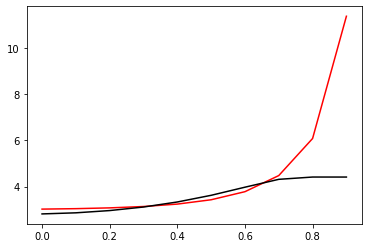

600 tensor(0.0004) [2.8192518, 2.8666928, 2.9643044, 3.1179152, 3.335961, 3.6249883, 3.9763412, 4.3170195, 4.416227, 4.4156523]


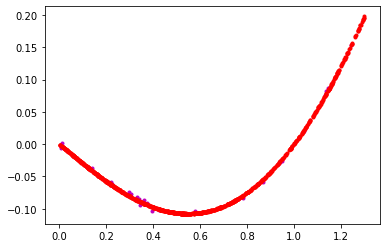

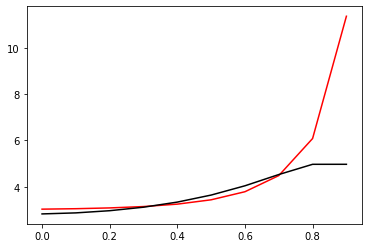

700 tensor(0.0004) [2.8212252, 2.8660064, 2.9603543, 3.11221, 3.3329926, 3.637471, 4.0390854, 4.5260572, 4.969082, 4.969618]


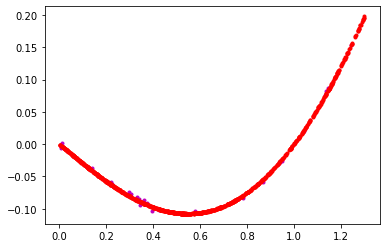

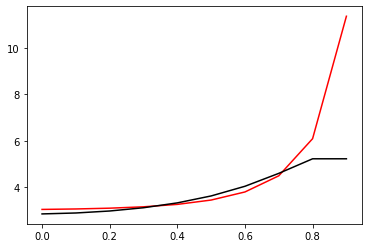

800 tensor(0.0003) [2.832731, 2.8729994, 2.9589477, 3.0997434, 3.3096883, 3.609812, 4.027924, 4.5861297, 5.2160816, 5.21659]


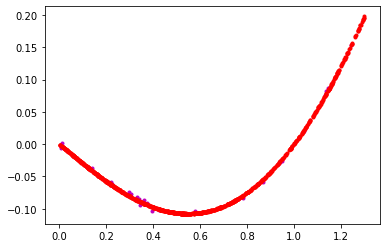

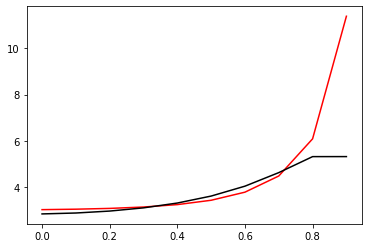

900 tensor(0.0004) [2.8427172, 2.8819277, 2.965906, 3.1042106, 3.31229, 3.6136217, 4.040937, 4.6263657, 5.317151, 5.318291]


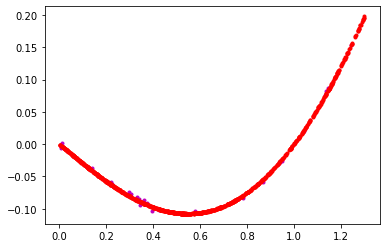

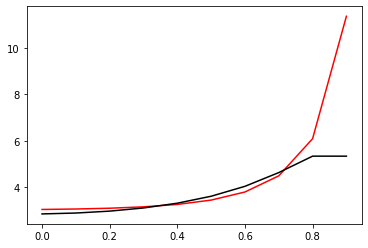

1000 tensor(0.0004) [2.8346026, 2.8727589, 2.955121, 3.0916219, 3.2980175, 3.5984793, 4.027542, 4.621431, 5.3318686, 5.3308578]


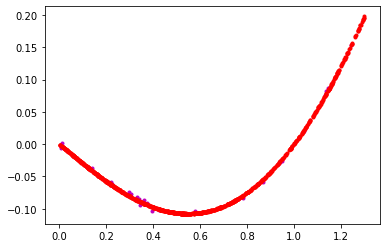

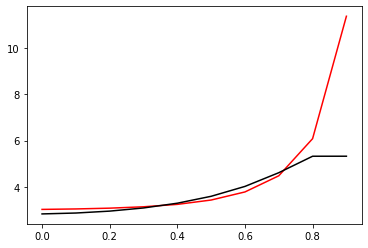

1100 tensor(0.0004) [2.8318932, 2.8704221, 2.9530737, 3.0893583, 3.2948549, 3.5937672, 4.021008, 4.613878, 5.326297, 5.3268204]


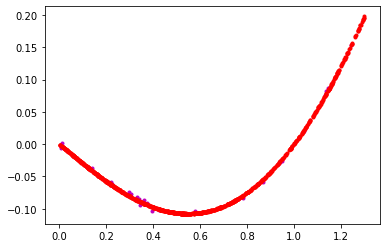

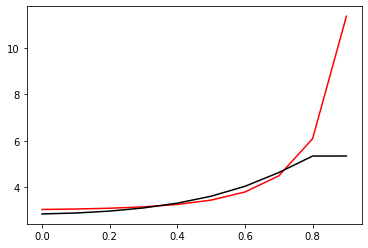

1200 tensor(0.0004) [2.8349588, 2.8737202, 2.9566054, 3.093323, 3.2996166, 3.599772, 4.0285897, 4.622953, 5.3361483, 5.3377867]


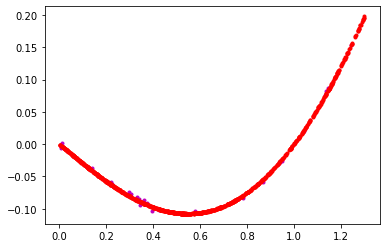

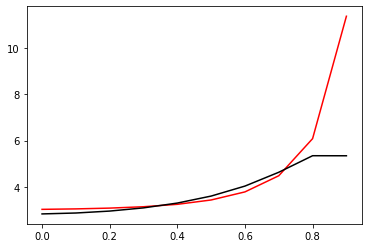

1300 tensor(0.0004) [2.8295977, 2.8688505, 2.9526434, 3.0906875, 3.2988014, 3.6014159, 4.033447, 4.631302, 5.3469496, 5.344615]


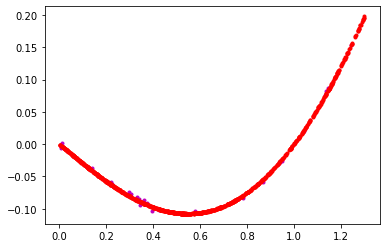

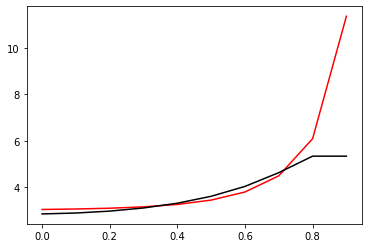

1400 tensor(0.0004) [2.834608, 2.8730865, 2.9554527, 3.091477, 3.2969046, 3.5960083, 4.0236917, 4.6172814, 5.331031, 5.330481]


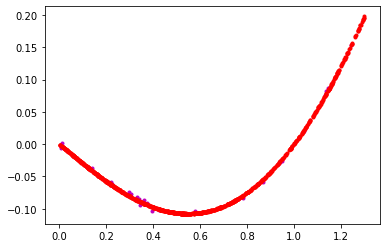

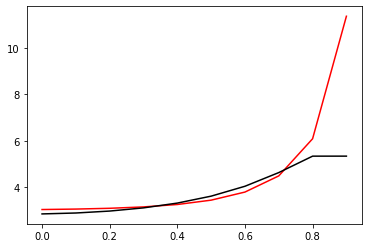

1500 tensor(0.0004) [2.83761, 2.87716, 2.961044, 3.098665, 3.3054419, 3.605264, 4.032498, 4.6238675, 5.3338256, 5.3343034]


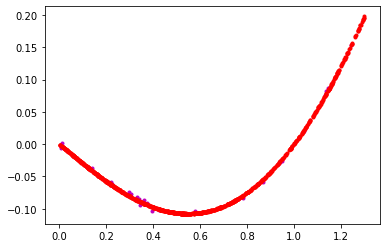

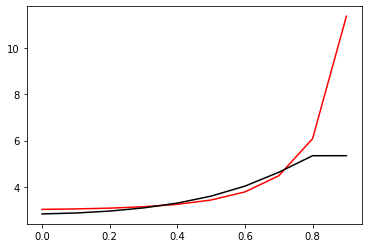

1600 tensor(0.0004) [2.8307657, 2.8699598, 2.9531732, 3.0904105, 3.297884, 3.6004007, 4.0330296, 4.6316924, 5.3474994, 5.3483534]


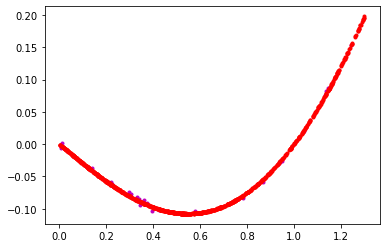

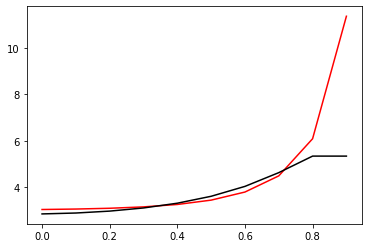

1700 tensor(0.0004) [2.8364532, 2.8752987, 2.9578724, 3.0938776, 3.299209, 3.5983357, 4.0262704, 4.620393, 5.335219, 5.334506]


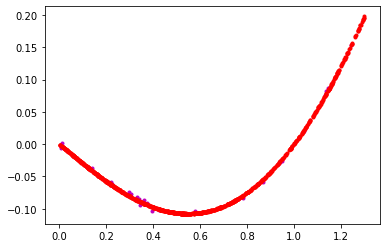

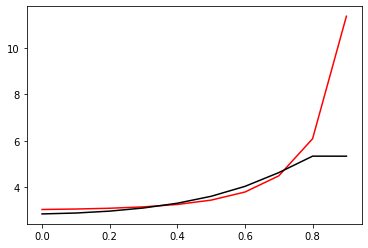

1800 tensor(0.0004) [2.8358219, 2.8741667, 2.9563184, 3.0921903, 3.2977226, 3.597455, 4.026322, 4.6206746, 5.332747, 5.330827]


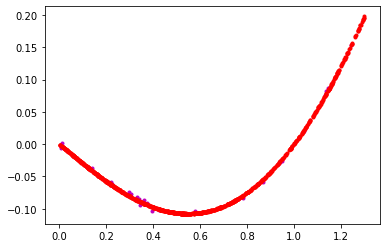

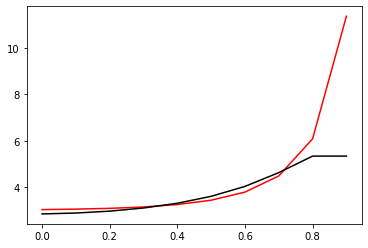

1900 tensor(0.0004) [2.8403616, 2.8783314, 2.9600868, 3.0955315, 3.300644, 3.5999672, 4.028548, 4.623407, 5.337793, 5.3385205]


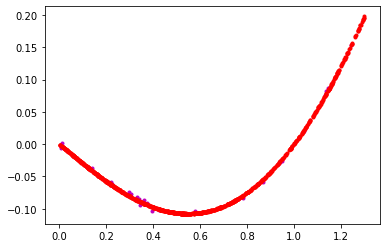

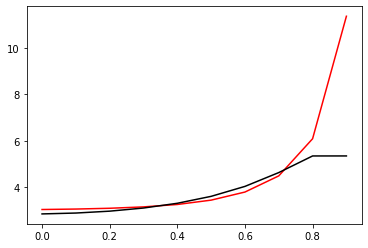

2000 tensor(0.0005) [2.8366802, 2.8745077, 2.955954, 3.0911775, 3.2963219, 3.5961373, 4.0260057, 4.623424, 5.341662, 5.342278]


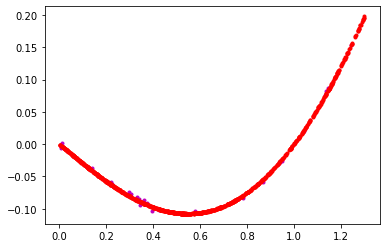

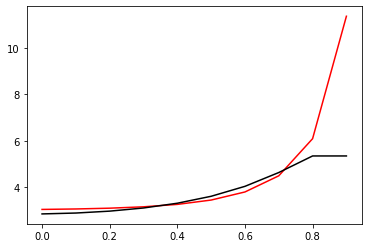

2100 tensor(0.0003) [2.832916, 2.87106, 2.9531794, 3.089162, 3.2949817, 3.595253, 4.0252476, 4.6222606, 5.3390718, 5.339158]


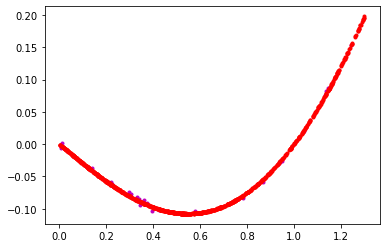

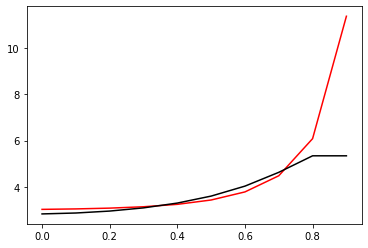

2200 tensor(0.0004) [2.8304949, 2.8698633, 2.9537537, 3.0916939, 3.2994244, 3.6013346, 4.032333, 4.629037, 5.343851, 5.343382]


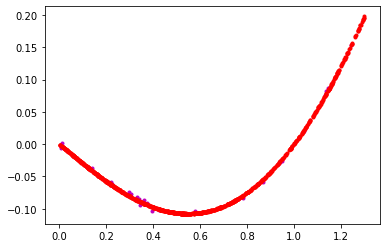

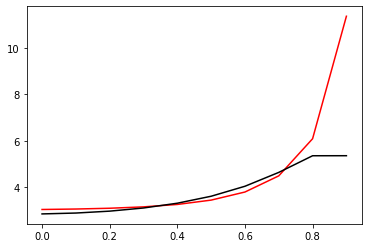

2300 tensor(0.0004) [2.835553, 2.8734074, 2.9554014, 3.0916429, 3.2981405, 3.599491, 4.0309753, 4.6301107, 5.3497453, 5.351351]


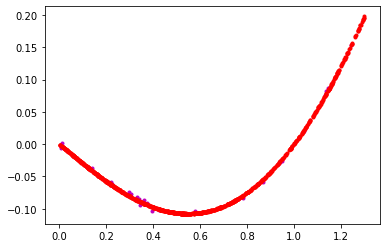

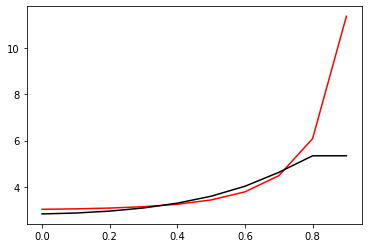

2400 tensor(0.0004) [2.8276005, 2.866013, 2.9486196, 3.0852742, 3.2919393, 3.593304, 4.0248036, 4.623777, 5.3425856, 5.3424106]


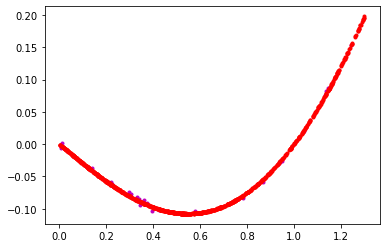

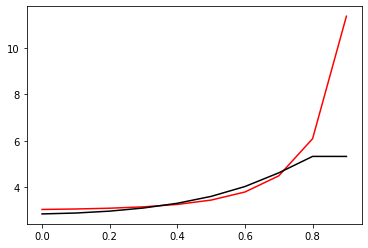

2500 tensor(0.0004) [2.8342602, 2.8725896, 2.9545753, 3.089875, 3.2942498, 3.5920532, 4.0181775, 4.6096587, 5.320573, 5.319429]


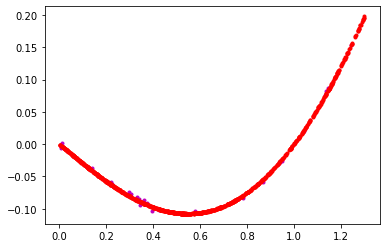

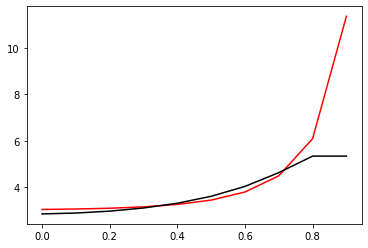

2600 tensor(0.0004) [2.8351007, 2.8730633, 2.9550548, 3.0909917, 3.2965791, 3.5960352, 4.0243044, 4.6188374, 5.3334107, 5.333552]


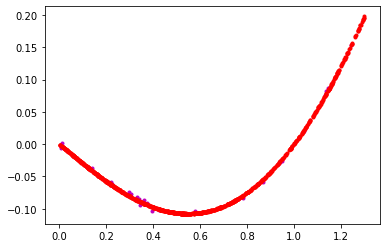

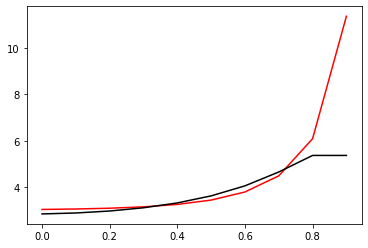

2700 tensor(0.0004) [2.8341238, 2.8744364, 2.959684, 3.0993638, 3.3092308, 3.6136353, 4.04727, 4.64629, 5.3626094, 5.362109]


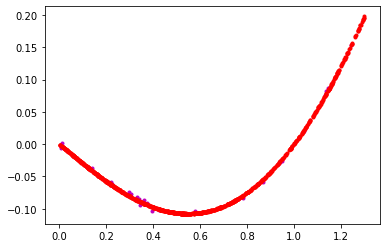

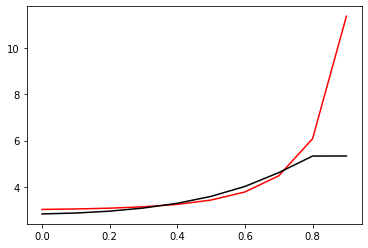

2800 tensor(0.0005) [2.8323374, 2.87014, 2.951649, 3.0869083, 3.291897, 3.5912266, 4.0202785, 4.6168547, 5.3347907, 5.336232]


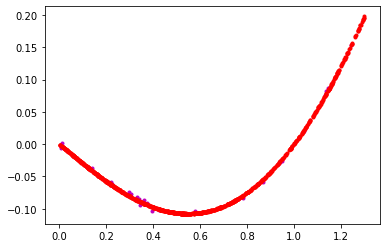

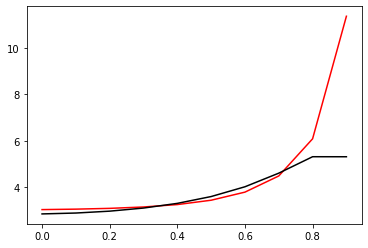

2900 tensor(0.0004) [2.8408113, 2.8790236, 2.960193, 3.094008, 3.29624, 3.591138, 4.013569, 4.601376, 5.3114004, 5.3103166]


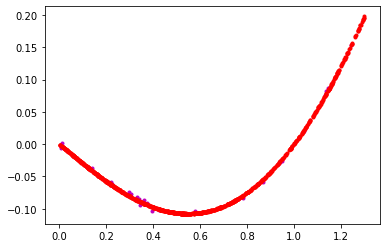

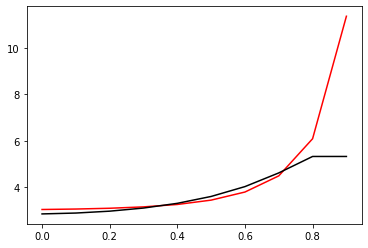

3000 tensor(0.0004) [2.8361413, 2.8737967, 2.9549928, 3.0896294, 3.2935078, 3.5909138, 4.0167246, 4.608231, 5.3194656, 5.3193407]


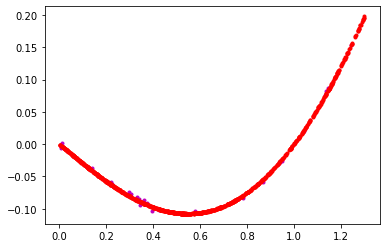

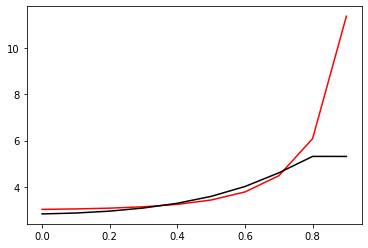

3100 tensor(0.0004) [2.831373, 2.8695722, 2.9516153, 3.0871766, 3.2918584, 3.589804, 4.015832, 4.607225, 5.31836, 5.317343]


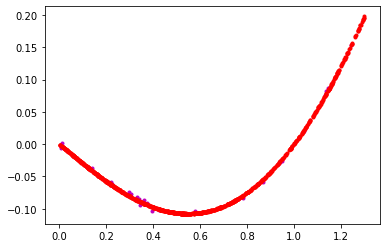

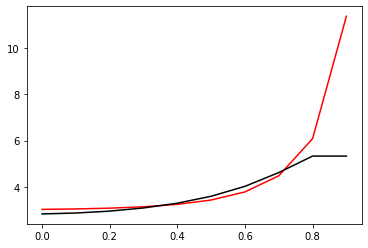

3200 tensor(0.0004) [2.8315642, 2.8699424, 2.9524765, 3.088914, 3.2949805, 3.5950043, 4.0239463, 4.618869, 5.332982, 5.3326206]


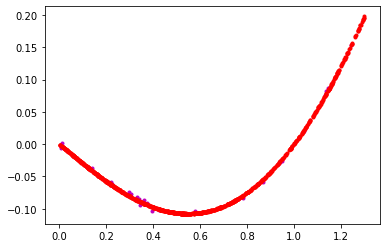

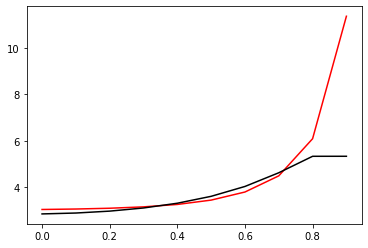

3300 tensor(0.0004) [2.835352, 2.8737423, 2.9560263, 3.0919478, 3.297126, 3.5956528, 4.022223, 4.6141725, 5.326081, 5.3268614]


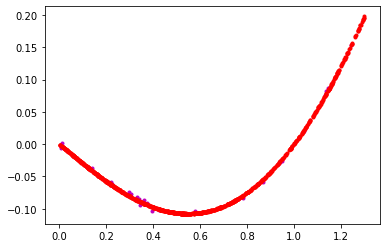

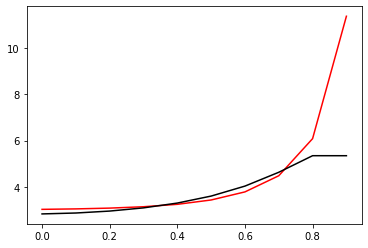

3400 tensor(0.0004) [2.8296728, 2.8689325, 2.9528775, 3.0909863, 3.298987, 3.601284, 4.0329103, 4.6309104, 5.347774, 5.3470645]


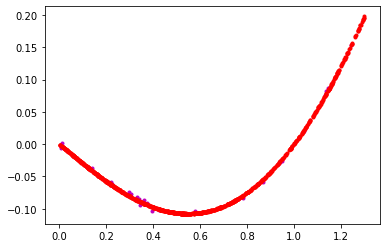

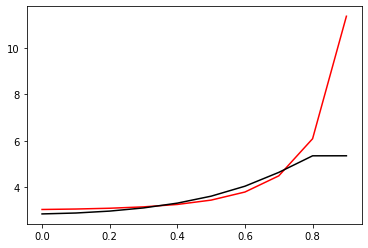

3500 tensor(0.0004) [2.8355408, 2.8745205, 2.957542, 3.0944295, 3.3011873, 3.602421, 4.033184, 4.6303678, 5.347032, 5.348271]


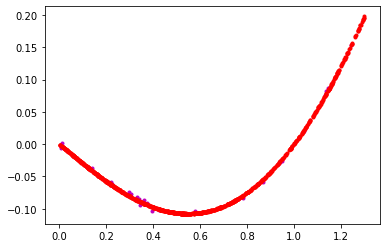

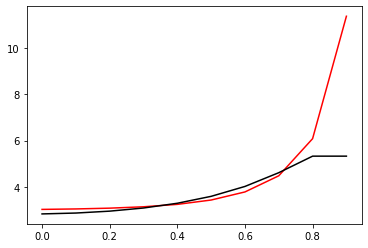

3600 tensor(0.0005) [2.8317807, 2.8696065, 2.951501, 3.087266, 3.2925735, 3.5917094, 4.0198026, 4.614463, 5.3294463, 5.3297086]


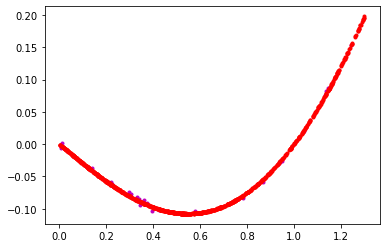

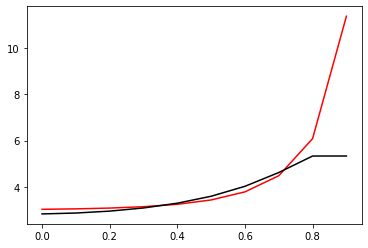

3700 tensor(0.0004) [2.8281808, 2.8665226, 2.9490168, 3.0854754, 3.2917707, 3.59243, 4.022564, 4.6188345, 5.333183, 5.3328776]


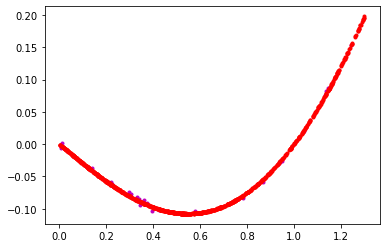

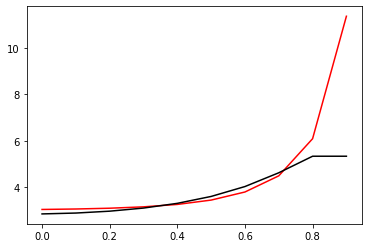

3800 tensor(0.0004) [2.8344057, 2.8719842, 2.9529114, 3.0873468, 3.2913923, 3.5897465, 4.017746, 4.6128106, 5.3282585, 5.3283553]


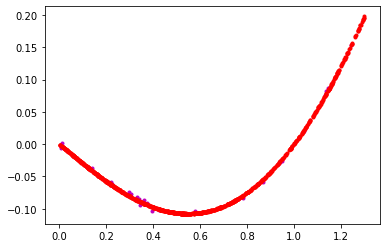

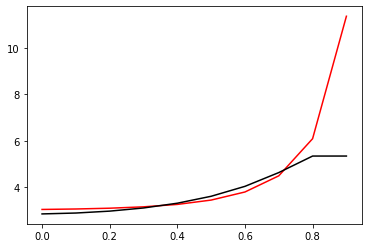

3900 tensor(0.0004) [2.833978, 2.87231, 2.9546275, 3.090745, 3.2965424, 3.5965333, 4.0257955, 4.621191, 5.3354683, 5.335826]


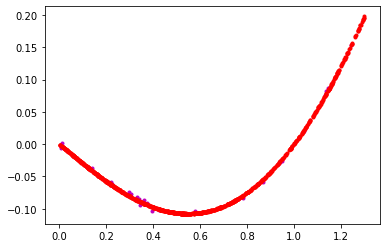

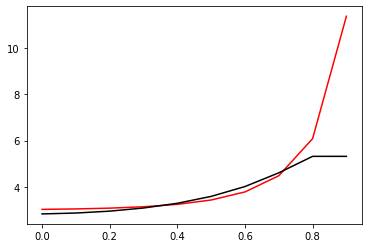

4000 tensor(0.0004) [2.8311436, 2.8691628, 2.9509745, 3.0862284, 3.2905884, 3.5883837, 4.014744, 4.6074243, 5.320635, 5.3209558]


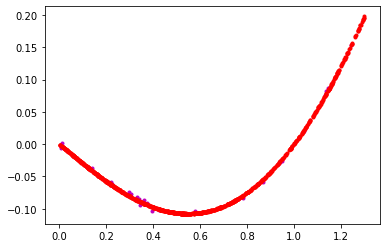

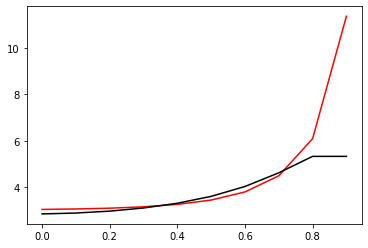

4100 tensor(0.0004) [2.83314, 2.8712993, 2.9533844, 3.0890388, 3.2939136, 3.5921865, 4.0186305, 4.6102686, 5.320905, 5.3212795]


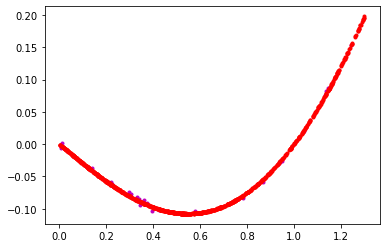

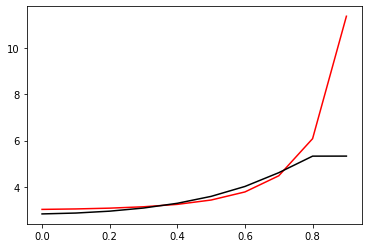

4200 tensor(0.0004) [2.8315132, 2.8692124, 2.9505944, 3.0858195, 3.2908566, 3.590209, 4.0190296, 4.614567, 5.330037, 5.331476]


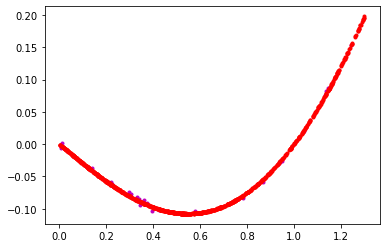

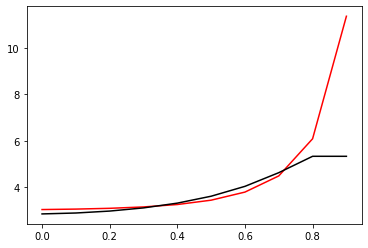

4300 tensor(0.0004) [2.8387003, 2.8781753, 2.96172, 3.098615, 3.3044443, 3.6033769, 4.0299554, 4.6205173, 5.328513, 5.327841]


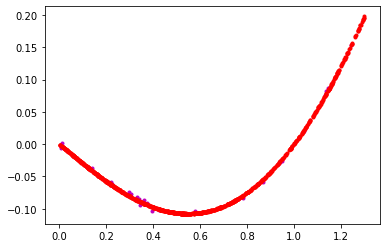

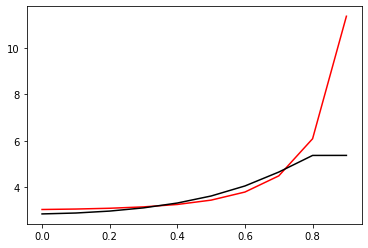

4400 tensor(0.0004) [2.8362463, 2.87511, 2.9588811, 3.0974214, 3.3065567, 3.6106546, 4.044602, 4.6451244, 5.3642206, 5.3653226]


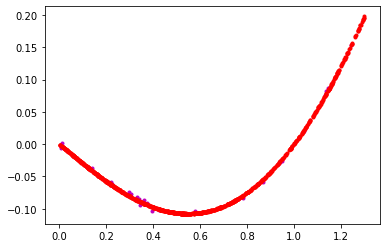

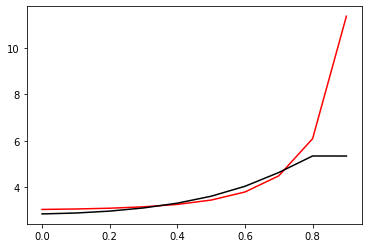

4500 tensor(0.0004) [2.8342078, 2.8728943, 2.9556355, 3.0922067, 3.2984154, 3.5987072, 4.0281367, 4.623812, 5.3390703, 5.3364353]


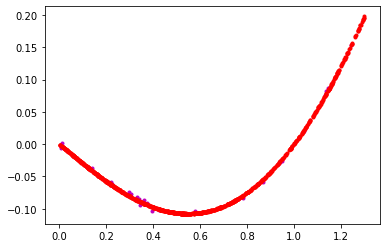

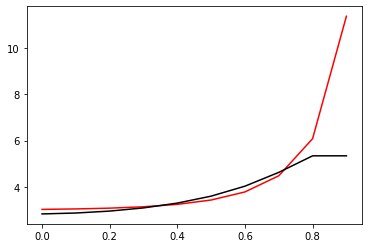

4600 tensor(0.0004) [2.8313632, 2.870314, 2.9536936, 3.091212, 3.298607, 3.6002386, 4.0310454, 4.627904, 5.3435984, 5.3434973]


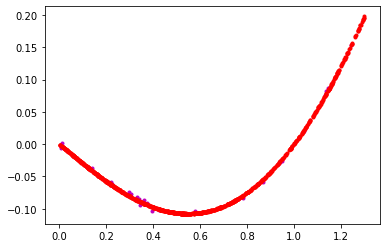

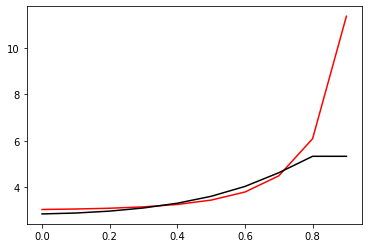

4700 tensor(0.0004) [2.8352468, 2.8737555, 2.9562433, 3.0923326, 3.2976317, 3.5962832, 4.0229797, 4.6147842, 5.3258905, 5.325522]


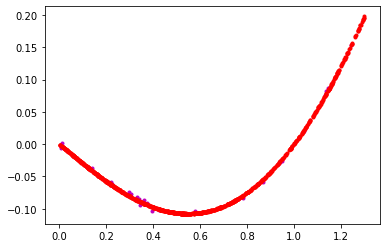

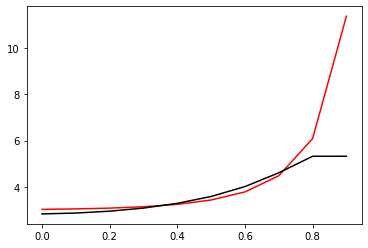

4800 tensor(0.0004) [2.830569, 2.8680823, 2.9489846, 3.0833375, 3.2871885, 3.5851817, 4.0127463, 4.607678, 5.3239675, 5.3247404]


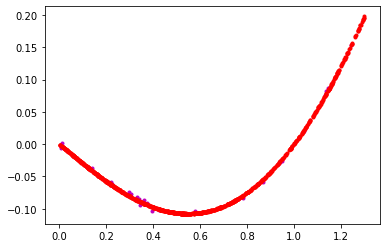

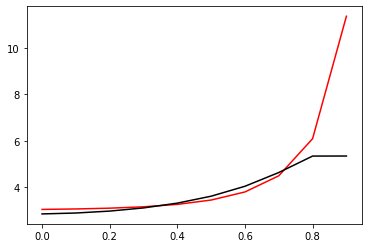

4900 tensor(0.0004) [2.8325307, 2.871614, 2.9547625, 3.0917215, 3.2983007, 3.5988226, 4.0279775, 4.6220336, 5.333908, 5.3357334]


In [10]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_metric(threshold=0.1, 
                                         Positive_HM=Positive_HM, Negative_HM=Negative_HM, Net=Test)
        print(epoch, train_loss/len(train_d_loader), Test.show_Hs())

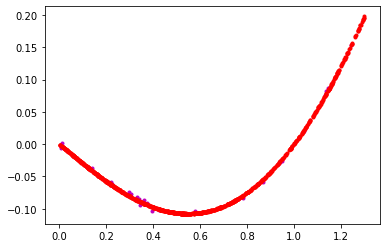

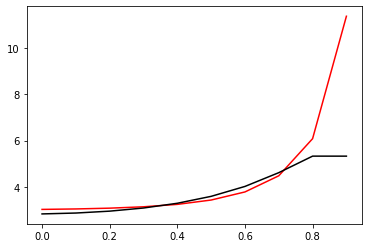

[2.831991, 2.870039, 2.951798, 3.087249, 3.2923427, 3.5916471, 4.0203757, 4.6157546, 5.3307285, 5.3297915]


In [11]:
nx, ny, px, py, Hs = plot_metric(threshold=0.1, 
                                         Positive_HM=Positive_HM, Negative_HM=Negative_HM, Net=Test)
print(Test.show_Hs())